<a href="https://colab.research.google.com/github/shpotes/stylegan2/blob/master/notebooks/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup
Stylegan2 está escrito en tensorflow 1, razon por la cual se debe cambiar el entorno

In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


Tambien es necesario descargar mi fork de stylegan2 y testear la GPU

In [2]:
!git clone https://github.com/shpotes/stylegan2
%cd stylegan2
!nvcc test_nvcc.cu -o test_nvcc -run

Cloning into 'stylegan2'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 273 (delta 0), reused 2 (delta 0), pack-reused 270
Receiving objects: 100% (273/273), 2.32 MiB | 35.97 MiB/s, done.
Resolving deltas: 100% (141/141), done.
/content/stylegan2
CPU says hello.
GPU says hello.


In [ ]:
!mkdir aligned
!mkdir generated

### Cargar tus propias imagenes
Se debe cargar la imagen a la cual se le desea cambiar el estilo en `raw/`

### Alineo de las imagenes.
Stylegan2 fue entrenado con FFHQ, un dataset de caras humanas. Para construirlo, se descagaron fotos de Flickr y automaticamente alineadas siguiendo el preocedimiento descrito en [[Kazemi & Sullivan, 2014]](https://ieeexplore.ieee.org/document/6909637). En consecuencia, si se desea aplicar efectivamente stylegan2 es necesrio realizar dicho preprocesamiento sobre las imagenes en consideracion.

La implementacion está basada en la realizada por [@rolux](https://github.com/rolux/stylegan2encoder)

In [12]:
!python align_images.py raw aligned

In [29]:
import matplotlib.pyplot as plt
from PIL import Image 
import textwrap
import os

def display_images(
    images: [Image.Image], 
    columns=5, width=20, height=8, max_images=15, 
    label_wrap_length=50, label_font_size=8):

    if not images:
        print("No images to display.")
        return 

    if len(images) > max_images:
        print(f"Showing {max_images} images of {len(images)}:")
        images=images[0:max_images]

    height = max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width, height))
    for i, image in enumerate(images):

        plt.subplot(len(images) / columns + 1, columns, i + 1)
        plt.imshow(image)
        plt.axis('off')

        if hasattr(image, 'filename'):
            title=image.filename
            if title.endswith("/"): title = title[0:-1]
            title=os.path.basename(title)
            title=textwrap.wrap(title, label_wrap_length)
            title="\n".join(title)

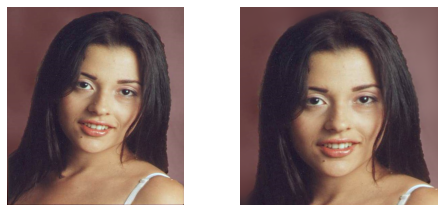

In [30]:
display_images(
    [Image.open('alejo.jpeg'), Image.open('aligned/alejo_01.jpeg.png')],
    columns=2,
    width=8,
)

### Stylegan magic
Es el momento de crear. Debido a que stylgan es una arquitectura generativa, esta no recibe imagenes de entrada. En consecuencia, se debe realizar un esfuerzo adicional para ingresar la imagen data. Antes de entrar en detalle, haré una breve introduccion a stylegan. 

La inestabilidad asociada al entrenamiento de las GANs hace complicado lograr escalarlas adecuadamente. [Karras et al [2018]](https://arxiv.org/abs/1710.10196v3) solucionan este problema en proGAN aumento progresivamente el tamaño del generador y discriminador, así el modelo empieza jugando con imagenes de baja resolucion. Durante el entrenamiento, al modelo se le agregan capaz que son tuneadas adecuadamente para aumentar progresivamente la resolucion de la imagen. Sin embargo, el generador resultante, al igual que el de la mayoría de GANs ofrece muy poco control de las imagenes generadas.
Para resolver esto, stylegan propone lo siguiente: En lugar de samplear la entrada de la GAN directamente de un espacio latente $Z$ (usualmente se sample ruido gaussiano), se aprende una entrada constante a partir de la cual se empiza a sintetizar la imagen. El vector latentt $z\in Z$ es mapeado a un espacio $W$ por una red neuronal. El proposito de esta red conocida como mapping network es precisamente aprender un espacio en el cual sea posible controlar mas facilmente la generacion. El resultado final observado, es un espacio $W$ en el cual, movimientos en este estan asociados a cambios semanticos en la imagen. 
el vector $w$ es agregado en los diferentes niveles de la imagen via adaptive instance normalization. 

Ok dude, pero.... ¿Como ingreso una imagen? [Dosovitskiy et al [2016]](https://arxiv.org/abs/1602.02644) propusieron un algoritmo eficiente para embeber imagenes en StyleGAN. Desde hace tiempo, es bien sabido en computer vision que el espacio de los pixeles es malo para comparar imagenes, sin embargo, al pasar estas imagenes por una red convolucional pre entrenada i.e. VGG, las features resultantes poseen una alta coherencia semantica, lo cual los hace buenos candidatos para comparar imagenes perceptualmente. En consecuencia, es posible construir un algoritmo de optimizacion en el cual se busque el vector latente que generó dicha imagen.


La implementacion oficial de stylegan posee un archivo llamado [`run_projection.sh`](https://github.com/NVlabs/stylegan2/blob/master/run_projector.py), es un poquito tricky hackearla, así que me hice mi propio script.

In [32]:
!python project_images.py --num-steps 500 aligned generated

Loading networks from "http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl"...
Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
Loading images from ".stylegan2-tmp/dataset/images"
detected 1 images ...
Creating dataset ".stylegan2-tmp/dataset/tfrecords"
Adding the images to tfrecords ...
added images 0
Added 1 images.
Projecting image "olquinte_01.png"...


Ok... ¿Entonces en teoria si pasamos esa imagen por stylegan deberíamos obtener una imagen parecida la de entrada?

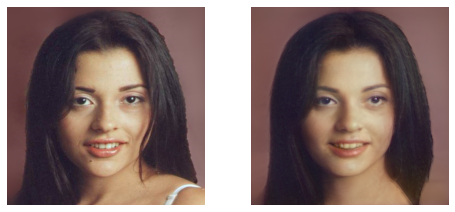

In [44]:
display_images(
    [Image.open('aligned/alejo_01.jpeg.png'), Image.open('generated/alejo_01.jpeg.png')],
    columns=2,
    width=8,
)

Vale, parece funcionar. Ahora ¿Como transferimos el estilo? Simple! la respusta está en el fine-tuning. Tipicamente cuando se fine tunea un modelo, se congelan las primeras capaz de la red y se tunean las ultimas. Esto se debe a que las primeras capaz suelen aprender features mas generales. Ahora esto tambien aplica en StyleGAN peeero, teniendo en cuenta, que este fue entrenado progresivamente, las primeras capaz (las cuales, condicionan las posteriores) fueron entrenadas para ser capaces la imagen, pero con una menor resolucion. Al fine tunear StyleGAN se observa una propiedad muy interesante y es que existe una consistencia entre los estilos del modelo inicial y el fine tuneado. En otras palabras, teniendo en cuenta que las primeras capaz generaran una version en baja resolucion de la imagen que esperamos. Las intermedias trataran de agregar mas resolucion e informacion a la imagen. Un modelo tuneado de stylegan en estas capaz intermedias no solo aumenta la resolucion sino que trata de afinar el estilo (pues para esto fue entrenado). 

En particular, utilicé los pesos entrenados por [@ak92501](https://twitter.com/ak92501/status/1282466682267676675?s=20). El utilizo MetFaces a una resloucion de 1024x1024 usando como base la configuracion f de stylegan2. 

Al realizar esto, se espera encontrar una version "pintada" de la cara de entrada.

In [46]:
import pretrained_networks

metfaces = 'https://drive.google.com/uc?id=1H-MYFZqngF1R0whm4bc3fEoX7VvOWaDl'
ffhq = 'http://d36zk2xti64re0.cloudfront.net/stylegan2/networks/stylegan2-ffhq-config-f.pkl'

_, _, Gs_blended = pretrained_networks.load_networks(metfaces)
_, _, Gs = pretrained_networks.load_networks(ffhq)

In [47]:
import numpy as np
from PIL import Image
import dnnlib
import dnnlib.tflib as tflib
from pathlib import Path

latent_dir = Path("generated")
latents = latent_dir.glob("*.npy")
for latent_file in latents:
  latent = np.load(latent_file)
  latent = np.expand_dims(latent,axis=0)
  synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=False), minibatch_size=8)
  images = Gs_blended.components.synthesis.run(latent, randomize_noise=False, **synthesis_kwargs)
  Image.fromarray(images.transpose((0,2,3,1))[0], 'RGB').save(latent_file.parent / (f"{latent_file.stem}-art.jpg"))

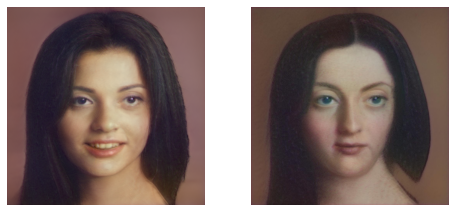

In [49]:
display_images(
    [Image.open('generated/alejo_01.jpeg.png'), Image.open('generated/alejo_01.jpeg-art.jpg')],
    columns=2,
    width=8,
)